In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from typing import Dict, List


# style.use('seaborn-v0_8-whitegrid')
from IPython.display import display

model_names = [
    'transformer',
    'resnet18',
    'resnet50'
    ]

# set this to be the same as the one in the experiment
model_idx = 2
batch_size = 256
model = model_names[model_idx]

data_file_pre = f'out/{model}_{batch_size}_pre.csv'
data_file_post = f'out/{model}_{batch_size}_post.csv'

df_pre = pd.read_csv(data_file_pre)
df_post = pd.read_csv(data_file_post)

In [3]:
def get_peak_memory_batch_size(model_idx):
    pass

In [4]:
def get_memory_decomp(df):
    memory_usages : Dict[str, np.array] = dict.fromkeys(['PARAM', 'OTHER', 'GRAD','ACT'])

    name_to_rank = {}
    for _, row in df.iterrows():
        name_to_rank[row['name']] = row['rank']

    for key in memory_usages.keys():
        memory_usages[key] = np.zeros(df.shape[0])

        for _, row in df.iterrows():
            # filter the elements belonging to this type
            if key not in row['type']:
                continue 

            start = row['rank']
            if row['op'] == 'placeholder':
                start = 0
                end = df.shape[0]
            else:
                end = df.shape[0]
                
                if not pd.isna(row['last_use']):
                    end = name_to_rank[row['last_use']]

            memory_usages[key][start:end] += row['size']
    
    memory_usage = np.zeros_like(memory_usages['ACT'])
    for key, val in memory_usages.items():
        memory_usage += val

    return memory_usages, memory_usage

In [5]:
no_ac_mem_breakdown, total_memory = get_memory_decomp(df_pre)

In [6]:
def plot_memory_over_time(df, suffix='pre', breakdown=True):
    name_to_rank = {}
    for _, row in df.iterrows():
        name_to_rank[row['name']] = row['rank']

    df['type'].value_counts()
    display(df.head())
    # display(df['type'].value_counts())
    
    # some preprocessing
    df['mem_cuda_GB'] = df.mem_cuda * 1e-9
    df['mem_cuda_pre_GB'] = df.mem_cuda_pre * 1e-9
    df['mem_cuda_peak_GB'] = df.mem_cuda_peak * 1e-9


    op_start = df[df.op == 'call_function']['rank'].min()
    sep_rank = df[df.name == 'sep']['rank'].item()
    sep_back_rank = df[df.name == 'sep_backward']['rank'].item()
    opt_start = df[df.name == '_foreach_lerp_']['rank'].item()

    # print(op_start, sep_rank, sep_back_rank, opt_start)

    df_grad = df[:opt_start]

    # make sure to give a minimum allocation size
    # DOES NOT CHANGE ANYTHING
    # df['size'] = df['size'].where(df['size'] > 512, 512)

    # compute memory usage here

    memory_breakdown, memory_usage = get_memory_decomp(df)
    
    plt.grid()
    plt.plot(df.mem_cuda_GB, color = 'k', alpha=1.0, label='Memory consumption (cuda)')
    
    if breakdown:
        x = list(range(len(memory_breakdown['ACT'])))
        
        ys = [val/1e9 for _, val in memory_breakdown.items()]
        labels = [key for key, _ in memory_breakdown.items()]
        plt.stackplot(x, ys, alpha=0.4, labels = labels)
    else:
        plt.plot(memory_usage/1e9, color='b', alpha=0.8, label='Predicted Memory')
    
    plt.title(f'Memory consumption - {model} (Batch size: {batch_size})', fontsize=14)
    plt.xlabel('Operations', fontsize = 14)
    plt.ylabel('Memory Consumption (GB)', fontsize = 14)

    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)

    plt.axvline(op_start, color='b', linestyle='--', alpha=0.3, label='Begin of forward pass')
    plt.axvline(sep_rank, color='r', linestyle='--', alpha=0.3, label='End of forward pass')
    plt.axvline(opt_start, color='g', linestyle='--', alpha=0.3, label = 'End of backward pass')
    plt.legend(fontsize=12)
    plt.savefig(f'figs/memory_prediction_{model}_{batch_size}_{suffix}.png')
    plt.show()

,rank,name,op,target,all_input_nodes,users,size,effective_size,runtime,type,mem_cuda,mem_cuda_pre,mem_cuda_peak,first_forward,last_forward,first_backward,last_backward,last_use
0,0,arg0_1,placeholder,arg0_1,[],"{convolution: None, convolution_backward_52: N...",37632.0,37632.0,0.018736,NodeType.PARAM,497733632,497733632,497733632,convolution,convolution,convolution_backward_52,copy__1932,copy__1932
1,1,arg0_2,placeholder,arg0_2,[],"{cudnn_batch_norm: None, cudnn_batch_norm_back...",256.0,256.0,0.012072,NodeType.PARAM,497733632,497733632,497733632,cudnn_batch_norm,cudnn_batch_norm,cudnn_batch_norm_backward_52,copy__1933,copy__1933
2,2,arg0_3,placeholder,arg0_3,[],"{cudnn_batch_norm: None, _foreach_addcdiv: Non...",256.0,256.0,0.011224,NodeType.PARAM,497733632,497733632,497733632,cudnn_batch_norm,cudnn_batch_norm,_foreach_addcdiv,copy__1934,copy__1934
3,3,arg0_4,placeholder,arg0_4,[],"{convolution_1: None, convolution_backward_51:...",16384.0,16384.0,0.010700,NodeType.PARAM,497733632,497733632,497733632,convolution_1,convolution_1,convolution_backward_51,copy__1935,copy__1935
4,4,arg0_5,placeholder,arg0_5,[],"{cudnn_batch_norm_1: None, cudnn_batch_norm_ba...",256.0,256.0,0.010460,NodeType.PARAM,497733632,497733632,497733632,cudnn_batch_norm_1,cudnn_batch_norm_1,cudnn_batch_norm_backward_51,copy__1936,copy__1936


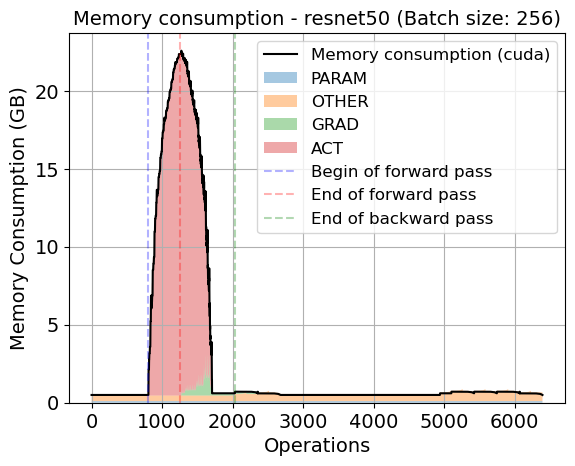

In [7]:
plot_memory_over_time(df_pre, suffix='pre')

,rank,name,op,target,all_input_nodes,users,size,effective_size,runtime,type,mem_cuda,mem_cuda_pre,mem_cuda_peak,first_forward,last_forward,first_backward,last_backward,last_use
0,0,arg0_1,placeholder,arg0_1,[],"{convolution: None, convolution_backward_52: N...",37632.0,37632.0,0.018608,NodeType.PARAM,497733632,497733632,13599690752,convolution,convolution,convolution_backward_52,copy__1932,copy__1932
1,1,arg0_2,placeholder,arg0_2,[],"{cudnn_batch_norm: None, cudnn_batch_norm_back...",256.0,256.0,0.021060,NodeType.PARAM,497733632,497733632,13599690752,cudnn_batch_norm,cudnn_batch_norm,cudnn_batch_norm_130,copy__1933,copy__1933
2,2,arg0_3,placeholder,arg0_3,[],"{cudnn_batch_norm: None, _foreach_addcdiv: Non...",256.0,256.0,0.013184,NodeType.PARAM,497733632,497733632,13599690752,cudnn_batch_norm,cudnn_batch_norm,cudnn_batch_norm_130,copy__1934,copy__1934
3,3,arg0_4,placeholder,arg0_4,[],"{convolution_1: None, _foreach_addcdiv: None, ...",16384.0,16384.0,0.011608,NodeType.PARAM,497733632,497733632,13599690752,convolution_1,convolution_1,convolution_57,copy__1935,copy__1935
4,4,arg0_5,placeholder,arg0_5,[],"{cudnn_batch_norm_1: None, cudnn_batch_norm_ba...",256.0,256.0,0.058252,NodeType.PARAM,497733632,497733632,13599690752,cudnn_batch_norm_1,cudnn_batch_norm_1,cudnn_batch_norm_88,copy__1936,copy__1936


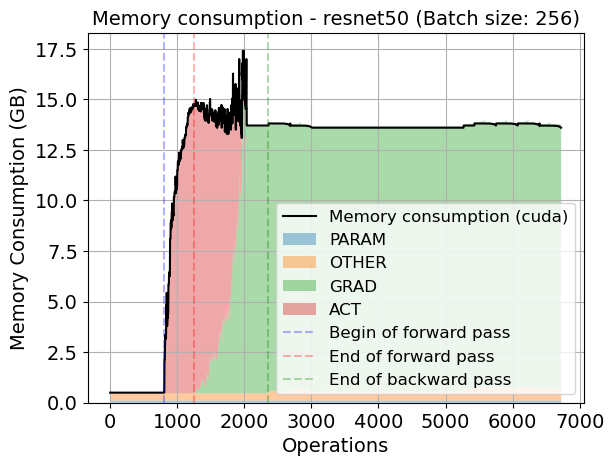

In [8]:
plot_memory_over_time(df_post, suffix='post', breakdown=True)